In [497]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import t
import nasdaqdatalink
import statsmodels.api as sm
from stepwise_regression.step_reg import *
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
import matplotlib.dates as dates

### Question One

Load in monthly house prices data in pounds sterling (£) from Jan 1991 to Dec 2016 from monthlyHousePricesUK.csv and the FTSE100 index from Yahoo Finance (ticker = ^FTSE) over the same period (01-Jan-1991 to 31-Dec-2016)<br><br>
#### a) Using the FTSE100 index monthly returns as dependent variable and the house prices monthly<br>
Using the FTSE100 index monthly returns as explanatory variable, create a regression model with MATLAB/Python including a constant and calculate the correlation coefficient (5points)

In [3]:
#Load the data from the excel file
monthly_data = pd.read_excel('Monthly.xls')
monthly_prices = monthly_data.rename(columns = {"Unnamed: 0": "Date"})

monthly_prices["Date"] = pd.to_datetime(monthly_prices["Date"])

#Set the date as the index
monthly_prices = monthly_prices.set_index("Date")

#Select the date range
monthly_mask = (monthly_prices.index >= '1991-01-01') & (monthly_prices.index <= '2016-12-31')
monthly_prices_filtered = monthly_prices.loc[monthly_mask]["Average House Price"].sort_index().copy().to_frame()

In [4]:
ftse_data = pd.read_csv('FTSE100.csv')
ftse_data["Date"] = pd.to_datetime(ftse_data["Date"])
ftse_data = ftse_data.set_index('Date')

ftse_mask = (ftse_data.index >= '1991-01-01') & (ftse_data.index <= '2016-12-31')

ftse_data_filtered = ftse_data.loc[ftse_mask]["Close"].sort_index().copy().to_frame()

In [662]:
monthly_prices_filtered["Returns"] = (
    monthly_prices_filtered["Average House Price"] / 
    monthly_prices_filtered["Average House Price"].shift(1)) - 1
ftse_data_filtered["Returns"] = (ftse_data_filtered["Close"] / ftse_data_filtered["Close"].shift(1)) - 1

In [684]:
slope, intercept, rvalue, pvalue, stderr = stats.linregress(
    monthly_prices_filtered["Returns"].dropna(),
    ftse_data_filtered["Returns"].dropna())

In [685]:
line_x = np.arange(monthly_prices_filtered["Returns"].min(),
                   monthly_prices_filtered["Returns"].max(), 0.01)
predicted_y = slope * line_x + intercept

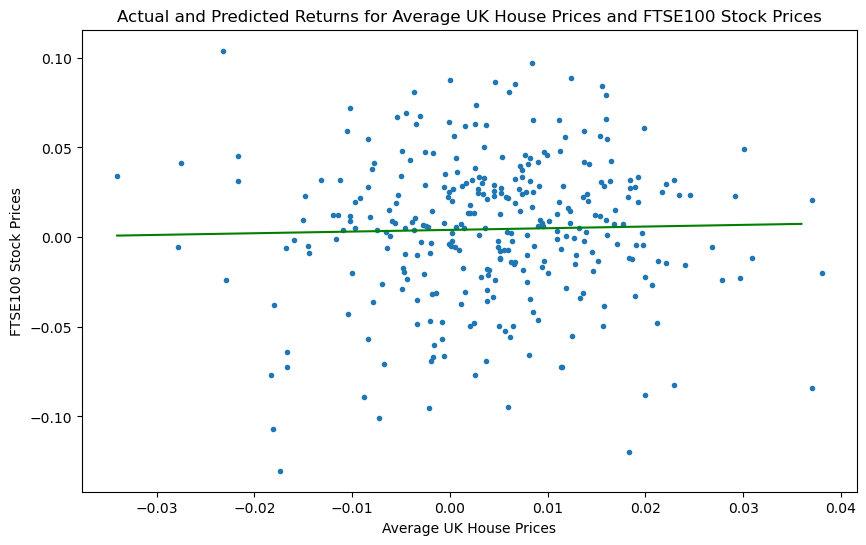

In [741]:
plt.figure(figsize = (10,6))
plt.title("Actual and Predicted Returns for Average UK House Prices and FTSE100 Stock Prices")
plt.xlabel("Average UK House Prices")
plt.ylabel("FTSE100 Stock Prices")
plt.scatter(monthly_prices_filtered["Returns"], ftse_data_filtered["Returns"], marker=".")
plt.plot(line_x, predicted_y, label = "Predictions", color="g")
plt.show()

In [687]:
coeff = np.corrcoef(np.array(monthly_prices_filtered["Returns"].dropna()), np.array(ftse_data_filtered["Returns"].dropna()))[0][1]
print(f"The correlation co-effecient is {coeff}")

The correlation co-effecient is 0.026551295701909918


#### b) What do the results tell us? (5 points)

The results tell us that changes in UK monthly house prices do not imapct FTSE100 prices due to the observations below:

- The points on the scatterplot show no pattern between the two datasets as they are widely spread.
- The linear regression prediction is nearly a straight line with no slope, so we cannot conclude a significant positive or negative relationship between the two datasets
 - The low positive correlation co-effecient also implies a weak relationship between the data

c) Use a hypothesis test to back up your conclusion about the existence of a significant relationship between these two variables. (10 points)

**Setting the null and alternative hypotheses:**

H0 (Null Hypothesis): slope = 0

HA (Alternative Hypothesis): slope ≠ 0

**Stating the significance level:**

α = 0.05

**Determining the appropriate test type (left-tail, right-tail or two-tailed test)**

A two-tailed test is appropriate because our alternative hypothesis is testing whether the slope is greater or less than 0, implying a positive or negative relationship between UK monthly house prices and FTSE100 index data. This value could lie on either side of the distribution curve, If so, we would infer that there is a relationship between UK monthly house prices and FTSE100 index data.

**Calculating the p-value**

In [688]:
# Calculate the t-statistic
t_statistic = slope / stderr

# Calculate the degree of freedom
degree_of_freedom = len(monthly_prices_filtered["Returns"]) - 1

# Calculate the p-value
pvalue = stats.t.sf(t_statistic, degree_of_freedom) * 2
print(f"p-value with a t-statistics of {t_statistic} and degree of freedom as {degree_of_freedom} is {pvalue}")

p-value with a t-statistics of 0.4668937880569304 and degree of freedom as 311 is 0.6409027850821407


**Conclusion**

The computed p-value of 0.6409027850821407 is greater than our significance level of 0.05. Therefore, we fail to reject the null hypothesis and can conclude that the slope = 0 implying that there is no relationship between UK monthly house prices and FTSE100 index data

### Question Two

The college.csv file contains information about different US colleges and universities. We are going to use
the number of applications received, the number of enrolled students, the number of out of state students,
the number of admitted students who were in the top 10% and number of admitted students who were in
the top 25% of their class to predict the graduation rate.<br><br>
#### a) Calculate the correlation coefficients of the aforementioned variables. (5 points)

In [668]:
#Load the college data and select the required columns
college_df = pd.read_csv("College.csv")
college_df = college_df.rename(columns = {"Unnamed: 0": "College"})
college_df = college_df.set_index("College")
college_data = college_df[["Grad.Rate", "Apps", "Enroll", "Outstate", "Top10perc", "Top25perc"]].copy()
college_data.corr()

,Grad.Rate,Apps,Enroll,Outstate,Top10perc,Top25perc
Grad.Rate,1.000000,0.146755,-0.022341,0.571290,0.494989,0.477281
Apps,0.146755,1.000000,0.846822,0.050159,0.338834,0.351640
Enroll,-0.022341,0.846822,1.000000,-0.155477,0.181294,0.226745
Outstate,0.571290,0.050159,-0.155477,1.000000,0.562331,0.489394
Top10perc,0.494989,0.338834,0.181294,0.562331,1.000000,0.891995
Top25perc,0.477281,0.351640,0.226745,0.489394,0.891995,1.000000


#### b) Considering the graduation rate as the dependent variable, use stepwise to build the linear regression model. (5 points)

In [669]:
# Setting the threshold as 0.05
alpha = 0.05
column_list = list(college_data.columns)
column_list.remove('Grad.Rate')

Define the X and Y columns

In [670]:
x_columns = college_data[column_list]
y = college_data["Grad.Rate"]

Run the backwards step regression on the dataset using the stepwise_regression library

In [671]:
print("The variables which affect graduation rate are:")
stepwise_results = backward_regression(x_columns, y, alpha,verbose=False) 
stepwise_results

The variables which affect graduation rate are:


['Apps', 'Enroll', 'Outstate', 'Top25perc']

#### c) Which predictor variables are useful in predicting the graduation rate? Explain how you got those variables. (5 points)

The predictor variables useful in predicting the graduation rate are number of applications('Apps'), number of enrolled students('Enroll'), the number of out of state students ('Outstate'), and number of admitted students who were in the top 25% of their class('Top25perc').

I got these variables by performing backwards step regression on the dataset using the stepwise_regression library.

With backwards stepwise regression, we use the function Ordinary Least Squares function to estimate the coefficients of linear regression equations between our dependent and independent variables. We then elimiate the features that have a p-value greater than the declared alpha value

#### d) Would the set of predictor variables be useful in predicting the graduation rate if you were to use BIC to select the model? Why? (5 points)

Run the sklearn LassoLarsIC() function with criterion as BIC to generate the co-effecients between the independent and dependent columns

In [283]:
bic_results =  sk.linear_model.LassoLarsIC(criterion = 'bic').fit(x_columns, y)

Loop through the bic_results model output to select the features with non-zero co-effecients, and add them to the list bic_features

In [284]:
feature_index = 0
bic_features = []
while feature_index < len(bic_results.coef_):
    if bic_results.coef_[feature_index] != 0:
        bic_features.append(bic_results.feature_names_in_[feature_index])
    feature_index += 1

In [285]:
print("The variables which affect graduation rate based on BIC selection are:")
bic_features

The variables which affect graduation rate based on BIC selection are:


['Apps', 'Enroll', 'Outstate', 'Top25perc']

#### e) Compare the accuracy of the model using only useful predictors with the accuracy of the model using all five predictors? (5 points)

In [482]:
model_full_predictors = sm.OLS(college_data['Grad.Rate'], sm.add_constant(college_data[column_list])).fit()
model_optimized_predictors = sm.OLS(college_data['Grad.Rate'], sm.add_constant(college_data[stepwise_results])).fit()

In [483]:
y_true_values = college_data['Grad.Rate']
y_predicted_values_full = model_full_predictors.predict(sm.add_constant(college_data[column_list]))
y_predicted_values_optimized = model_optimized_predictors.predict(sm.add_constant(college_data[stepwise_results]))

In [484]:
mse_full = mean_squared_error(y_true_values, y_predicted_values_full)
mse_optimized = mean_squared_error(y_true_values, y_predicted_values_optmized)

print(f"Mean-squared error with all five predictors is {mse_full}.\nMean-squared error with only useful predictors is {mse_optmized}")

Mean-squared error with all five predictors is 180.8954688977305.
Mean-squared error with only useful predictors is 181.03167157338038


For a linear regression model, the mean-squared error measures the amount of error in statistical models. Therefore, the lower the mean-squared error the better. From the above, we can conclude that the model is more accurate when using all five predictors

#### f) Given a set of predictors corresponding to Carnegie Mellon University, what graduation rate value should the most accurate model predict? (5 points)

In [485]:
cmu_predictors = college_data[column_list].iloc[college_data[column_list].index == "Carnegie Mellon University"]
cmu_predictors_set = sm.add_constant(cmu_predictors, has_constant="add")
cmu_predicted_value = model_full_predictors.predict(cmu_predictors_set)

In [486]:
print(f"CMU predicted graduation rate is {cmu_predicted_value[0]}")

CMU predicted graduation rate is 89.2011230534684


### Question Three

Design and undertake a study to assess a trend in the domain of transport for one or more countries of your choice. Your study should be based on publicly available data and explained using mathematical facts. Explain assumptions, methodology and findings. An example would be to study the relationship between increase in transport and road traffic accidents. The World Health Organization has data for road traffic deaths per country in 2010 and there is a World Bank indicator for Passenger cars (per 1000 people). Can you predict the situation in 2021?<br><br>
Deliverables: You should turn in a report that includes the trend you are studying, the data source (5 points), your assumptions (5points), the methodology used along with its implementation in MATLAB/Python (10 points), and finally the findings and conclusions, which should be backed with code and figures (10 points).

### Solution

The trend I will be studying is the relation between GDP Per Capita and Mortality caused by road traffic injury in Uganda

In [487]:
#Load the GDP data and metadata from the dowloaded files
gdp_data = pd.read_csv('GDP_Per_Capita.csv', skiprows = 4, index_col=1)
gdp_metadata = pd.read_csv('Metadata_Country_API_GDP_Per_Capita.csv', index_col=0)
#Drop the columns named 'Unnamed'
gdp_metadata.drop(gdp_metadata.filter(regex="Unnamed"),axis=1, inplace=True)
gdp_data.drop(gdp_data.filter(regex="Unnamed"),axis=1, inplace=True)

In [488]:
#Load the mortality data and metadata from the dowloaded files
mortality_data = pd.read_csv('Mortality_Data.csv', skiprows = 4, index_col=1)
mortality_metadata = pd.read_csv('Mortality_Data_Metadata.csv', index_col=0)
#Drop the columns named 'Unnamed'
mortality_metadata.drop(mortality_metadata.filter(regex="Unnamed"),axis=1, inplace=True)
mortality_data.drop(mortality_data.filter(regex="Unnamed"),axis=1, inplace=True)

In [489]:
#Merge the GDP data and metadata dataframes into one dataframe
gdp_df = pd.merge(gdp_metadata,gdp_data,on='Country Code')
#Merge the mortality prevalance data and metadata dataframes into one dataframe
mortality_df = pd.merge(mortality_metadata,mortality_data,on='Country Code')

In [474]:
#Trim the GDP and malnutrition prevalance dataframes by dropping columns we will not use
gdp_df_trim = gdp_df.drop(["Region","IncomeGroup","TableName","Country Name","Indicator Name","Indicator Code","SpecialNotes"], axis=1)
mortality_df_trim = mortality_df.drop(["Region","IncomeGroup","TableName","Country Name","Indicator Name","Indicator Code","SpecialNotes"], axis=1)

In [758]:
gdp_ug_preformat = gdp_df_trim.iloc[gdp_df_trim.index == "UGA"]
mortality_ug_preformat = mortality_df_trim.iloc[mortality_df_trim.index == "UGA"]

In [769]:
gdp_ug = gdp_ug_preformat.melt(ignore_index=False,var_name="Year", value_name="GDP")
gdp_ug = gdp_ug.set_index("Year")

mortality_ug = mortality_ug_preformat.melt(ignore_index=False,var_name="Year", value_name="Mortality")
mortality_ug = mortality_ug.set_index("Year")

In [770]:
gdp_mortality_model = sm.OLS(mortality_ug["Mortality"], sm.add_constant(gdp_ug["GDP"]), missing="drop").fit()

In [771]:
x_line_ug = np.arange(gdp_ug["GDP"].min(), gdp_ug["GDP"].max(), 1)

In [772]:
predicted_y_ug = gdp_mortality_model.predict(sm.add_constant(x_line_ug))

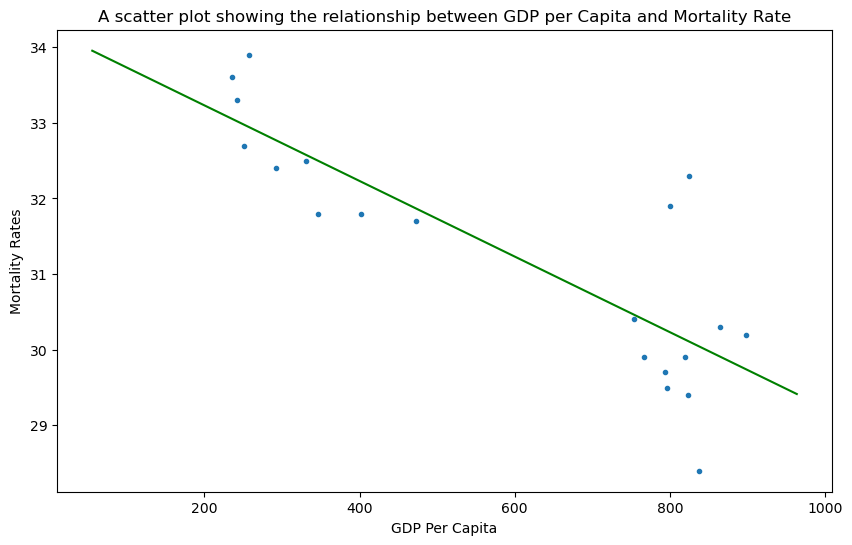

In [773]:
plt.figure(figsize = (10,6))
plt.title("A scatter plot showing the relationship between GDP per Capita and Mortality Rate")
plt.xlabel("GDP Per Capita")
plt.ylabel("Mortality Rates")
plt.scatter(gdp_ug["GDP"], mortality_ug["Mortality"], marker=".")
plt.plot(x_line_ug, predicted_y_ug, label = "Predictions", color="g")
plt.show()

The results show us that there is a strong negative relationship between GDP Per Capita and Mortality Rate, mortality rate decreases as GDP per Capita increases.

**Setting the null and alternative hypotheses:**

H0 (Null Hypothesis): slope = 0

HA (Alternative Hypothesis): slope ≠ 0

**Stating the significance level:**

α = 0.05

**Determining the appropriate test type (left-tail, right-tail or two-tailed test)**

A two-tailed test is appropriate because our alternative hypothesis is testing whether the slope is greater or less than 0, implying a positive or negative relationship between GDP Per Capita and Mortality Rate. This value could lie on either side of the distribution curve, If so, we would infer that there is a relationship between GDP Per Capita and Mortality Rate.

**Selecting the p-value**

In [775]:
gdp_pvalue = gdp_mortality_model.pvalues["GDP"]

The computed p-value of 5.298256602609201e-06 is less than our alpha value of 0.05. We can reject the null hypothesis and accept the alternative hypothesis that that the slope is not equal to 0. Therefore, we confirm that there is a relationship between GDP Per Capita and Mortality Rate

### Question Four

The bank of Israel has published the data for unemployment rate (per 100 Israeli workforces) from 1980-12-31 to 2013-09-02. Download the data from Quandl (code: ODA/ISR_LUR) into MATLAB/Python

In [335]:
unemployment_api_data = nasdaqdatalink.get("ODA/ISR_LUR")

In [558]:
mask = (unemployment_api_data.index >= '1980-12-31') & (unemployment_api_data.index <= '2013-09-02')
unemployment_data = unemployment_api_data.iloc[mask]

#### a) Estimate the likely rate of unemployment by the year 2020 (10 points)

In [652]:
date_values = dates.date2num(unemployment_data.index)
date_values = sm.add_constant(date_values)

unemployment_rate_model = sm.OLS(unemployment_data["Value"], date_values).fit()

In [653]:
future_date_val = dates.date2num(['2020-12-31'])
future_date_val = sm.add_constant(future_date_val, has_constant="add")

In [654]:
predicted_unemployment_rate = unemployment_rate_model.predict(future_date_val)

print(f"The likely rate of unemployment by the year 2020 is {predicted_unemployment_rate[0]}")

The likely rate of unemployment by the year 2020 is 12.078691048979872


#### b) Explain how one can evaluate the accuracy of the estimate (5 points)

One can evaluate the accuracy of the estimate by finding the mean absolute percentage error(MAPE) between the true dependent / y values and the predicted dependent / y values. The MAPE is the measure of prediction accuracy of a model

In [672]:
unemployment_y_true = unemployment_data['Value']
unemployment_y_predicted = unemployment_rate_model.predict()

In [673]:
mape = mean_absolute_percentage_error(unemployment_y_true, unemployment_y_predicted)
print(f"The estimate has an accuracy of {mape}")

The estimate has an accuracy of 0.21992602606313427


#### c) Provide the accuracy as a percentage (5 points)

In [659]:
mape_pct = mape * 100
print(f"The accuracy as a percentage is {round(mape_pct, 4)}%")

The accuracy as a percentage is 21.9926%
